# LaB-RAG : Label Boosted Retrieval Augmented Generation for Radiology Report Generation
#### Steven Song\*, Anirudh Subramanyam\*, Irene Madejski, Robert L. Grossman
\* Equal contribution

Read our paper here: https://arxiv.org/abs/2411.16523

***

In the current paradigm of image captioning, deep learning models are trained to generate text from image embeddings of latent features. We challenge the assumption that fine-tuning of large, bespoke models is required to improve model generation accuracy. We propose Label Boosted Retrieval Augmented Generation (LaB-RAG), a small-model-based approach to image captioning that leverages image descriptors in the form of categorical labels to boost standard retrieval augmented generation (RAG) with pretrained large language models (LLMs). This notebook demonstrates LaB-RAG applied to radiology report generation (RRG).

* **Simple models over zero-shot embeddings can effectively classify X-rays**. In combination with standard RAG, these derived labels can be used with general-domain LLMs to generate radiology reports.
* Without ever training our generative language model or image embedding models specifically for the RRG task, and without ever directly "showing" the LLM an X-ray, LaB-RAG is able to generate coherent and grounded reports. 
* The results presented in our paper demonstrate that LaB-RAG is competitive with models trained specifically for RRG and that LaB-RAG may have broader compatibility and synergy with fine-tuned methods to further enhance RRG performance.

## Overview

<img src="https://raw.githubusercontent.com/uc-cdis/label-boosted-RAG-for-RRG/refs/heads/main/figs/overview/conceptual.png" alt="conceptual overview figure" width="50%"/>

Conceptually, the LaB-RAG method uses small models to classify images and injects the image labels between the steps of standard RAG. For image embeddings, we use the image encoder arm of BioViL-T ([Bannur et al. 2023](https://openaccess.thecvf.com/content/CVPR2023/papers/Bannur_Learning_To_Exploit_Temporal_Structure_for_Biomedical_Vision-Language_Processing_CVPR_2023_paper.pdf)) and derive both projected and unprojected embeddings. In this demo, we use MedGemma-4B ([Sellergren et al. 2025](https://arxiv.org/abs/2507.05201)) as our generative language model as LaB-RAG is synergistic with other model improvements, such as domain adaptation. We specifically use a [GGUF quantized version of MedGemma-4B](https://huggingface.co/unsloth/medgemma-4b-it-GGUF) served from the inference service of the commons.

We can specifically break down the required steps for RRG as the following:
1. Download retrieval embeddings, reports, and labels
1. Train classifier model
1. Load embedding model
1. Download, embed, and classify inference image
1. Compute similarities
1. Filter similarities
1. Retrieve reports and labels
1. Prepare prompt
1. Generate new report

In [ ]:
!pip install h5py pandas numpy tqdm pqdm scikit-learn hi-ml-multimodal==0.2.2 torch torchvision openai gen3

### Download Retrieval Embeddings, Reports, and Labels
This retrieves embeddings using the AI commons embedding service!

In [1]:
labels = ["Cardiomegaly", "Edema", "Consolidation", "Atelectasis", "Pleural Effusion"]

In [2]:
import json
import requests
from requests.adapters import HTTPAdapter, Retry

import numpy as np
import pandas as pd
from tqdm import tqdm
from pqdm.threads import pqdm
from gen3.auth import Gen3Auth

# Some helpers for sending API requests to the commons
auth = Gen3Auth()
session = requests.Session()

retry_strategy = Retry(
    total=5,
    backoff_factor=0.1,
    status_forcelist=[429, 500, 502, 503, 504],
)

adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("https://", adapter)

# It's ongoing work to enable batch download so for now,
# use multithreading to parallelize requests
def query(guid):
    response = session.get(
        f"https://m3aicommons.org/user/data/download/{guid}",
        auth=auth,
    )
    response.raise_for_status()
    return response.json()["url"]

def get_metadata(file_id):
    response = session.get(
        f"https://m3aicommons.org/mds/metadata/{file_id}",
        auth=auth,
    )
    response.raise_for_status()
    return response.json()

X_emb = []
X_proj = []

manifest_emb = "manifests/openi-5-embed.json"
manifest_proj = "manifests/openi-5-proj.json"

# Critical for LaB-RAG, data must be correctly paired
with open(manifest_emb, "r") as f_emb, open(manifest_proj, "r") as f_proj:
    embs = json.load(f_emb)
    projs = json.load(f_proj)
    for emb, proj in zip(embs, projs):
        assert emb["file_id"] == proj["file_id"], "Mismatched embedding and projection order"

for i, (fpath, X) in enumerate([
    (manifest_emb, X_emb),
    (manifest_proj, X_proj),
]):
    with open(fpath, "r") as f:
        manifest = json.load(f)
        file_ids = [x["file_id"] for x in manifest]
        guids = [x["guid"] for x in manifest]
    temp = pqdm(guids, query, n_jobs=40)
    for x in tqdm(temp):
        X.append(json.loads(x["embedding"]))

# only need to get metadata once, do at the end
metadata = pqdm(file_ids, get_metadata, n_jobs=40)

X_emb = np.asarray(X_emb)
X_proj = np.asarray(X_proj)
df = pd.DataFrame(metadata)[["file_id", "Reports"] + labels]
df[labels] = df[labels].astype(int)

QUEUEING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/620 [00:00<?, ?it/s]

100%|██████████| 620/620 [00:00<00:00, 7094.97it/s]


QUEUEING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/620 [00:00<?, ?it/s]

100%|██████████| 620/620 [00:00<00:00, 49647.16it/s]


QUEUEING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/620 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/620 [00:00<?, ?it/s]

### Train Embedding Classifier Model

In [3]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score

In [4]:
models = {
    label: TunedThresholdClassifierCV(
        LogisticRegression(
            random_state=42,
        ),
        scoring=make_scorer(f1_score),
        random_state=42,
    ).fit(X_emb, df[label].to_numpy())
    for label in tqdm(labels, desc="Training Classifiers")
}

Training Classifiers: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


### Load Embedding Model

In [5]:
from health_multimodal.image.model.pretrained import (
    ImageModel,
    ImageEncoderType,
    JOINT_FEATURE_SIZE,
)
from huggingface_hub import try_to_load_from_cache

model = ImageModel(
    img_encoder_type=ImageEncoderType.RESNET50_MULTI_IMAGE,
    joint_feature_size=JOINT_FEATURE_SIZE,
    pretrained_model_path=try_to_load_from_cache(
        "microsoft/BiomedVLP-BioViL-T",
        "biovil_t_image_model_proj_size_128.pt",
        revision="v1.0",
    ),
).eval()

/opt/gpudata/steven/miniforge3/envs/demo/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Download, Embed, and Classify Inference Image

In [6]:
import requests
from pathlib import Path

import torch
from health_multimodal.image.data.io import load_image
from health_multimodal.image.data.transforms import create_chest_xray_transform_for_inference

In [7]:
# This image is not in our embedding service as it does not have a ground-truth findings section
# and we limited the demo embeddings to only images with a corresponding findings section.
target_img_url = "https://openi.nlm.nih.gov/imgs/512/73/73/CXR73_IM-2289-1001.png"

target_gt_impression = (
    "Improved basilar aeration. Persistent small bilateral pleural effusions, "
    "XXXX on the right, small on the left with some associated left basilar atelectasis. "
    "Lungs otherwise clear. Unremarkable mediastinal contour. Changes of emphysema. "
    "No XXXX acute abnormalities since the previous chest radiograph."
)

In [8]:
# Download and Load Image
tmp_path = Path("target.png")
response = requests.get(target_img_url)
response.raise_for_status()
with open(tmp_path, "wb") as f:
    f.write(response.content)

im_ = load_image(tmp_path)

transform = create_chest_xray_transform_for_inference(
    resize=512,
    center_crop_size=448,
)
im = transform(im_)

In [9]:
# Compute Embeddings
out = model(im.unsqueeze(0))
with torch.inference_mode():
    img_embed = out.img_embedding.cpu().numpy()
    img_proj = out.projected_global_embedding.cpu().numpy()

In [10]:
# Classify Image
target_labels = {
    label: models[label].predict(img_embed)[0]
    for label in labels
}

In [11]:
target_labels

{'Cardiomegaly': np.int64(0),
 'Edema': np.int64(0),
 'Consolidation': np.int64(0),
 'Atelectasis': np.int64(1),
 'Pleural Effusion': np.int64(1)}

### Compute Similarities

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(X_proj, img_proj).squeeze()

### Filter Similarities

In [13]:
# Exact Filter
mask = df["file_id"].notna()
for label in labels:
    mask &= (df[label] == target_labels[label])

### Retrieve Reports and Labels

In [14]:
import numpy as np

k = 5 # top-k retrieval
masked_sims = sims[mask] # only consider samples with exact label match
masked_idxs = np.argwhere(mask).squeeze() # keep track of which samples we use
top_k_masked_idxs = np.argsort(masked_sims)[-k:][::-1] # get top-k most similar in ranked order
top_k_idxs = masked_idxs[top_k_masked_idxs] # map back to original indices

In [15]:
retrieved_df = df.iloc[top_k_idxs][["file_id", "Reports"] + labels]
retrieved_df

,file_id,Reports,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
9,CXR1043_IM-0035-0001-0002,Normal cardiomediastinal silhouette. Interval ...,0,0,0,1,1
482,CXR3846_IM-1946-1001,Heart size and mediastinal contour are normal....,0,0,0,1,1
386,CXR3249_IM-1539-1001,The XXXX examination consists of frontal and l...,0,0,0,1,1
111,CXR1649_IM-0426-1001,There is a moderate layering left pleural effu...,0,0,0,1,1
338,CXR2961_IM-1355-1001,There is patchy opacity in the left base conce...,0,0,0,1,1


### Prepare Prompt

In [16]:
examples = []
for i, (_, row) in enumerate(retrieved_df.iterrows()):
    example = (
        f"Example: {i+1}\n"
        f"Label: {', '.join(l for l in labels if row[l] == 1)}\n"
        f"Report: {row['Reports']}\n"
    )
    examples.append(example)
examples = '\n'.join(examples)

In [17]:
# Simple Prompt Format (slightly modified for chat template)
messages = [
    {
        "role": "system",
        "content": (
            "You are an expert radiological assistant.\n"
            "Your task is to generate a radiology report given example reports in a user provided context.\n"
            "The context information contains examples of reports written for similar cases and their associated labels.\n"
            "Use the examples and their associated labels to generate a report for the current case based on the current label.\n"
            "Strictly follow the instructions below to generate the reports."
        ),
    },
    {
        "role": "user",
        "content": (
            "**Instructions**\n\n"
            "1. The report must be based on the information in the context and the current label.\n"
            "2. The report must mimic the style of the reports shown in the context.\n"
            "3. Do not generate blank reports.\n"
            "\n"
            f"CONTEXT:\n{examples}\n"
            "Now generate the report for the current case using its label below. Always generate reports based on the examples shown.\n"
            f"Label: {', '.join(l for l in labels if row[l] == 1)}\n"
            "Report: "
        ),
    },
]

### Generate New Report

In [18]:
from openai import Client

client = Client(
    base_url="https://apps.m3aicommons.org/medgammav1", # TODO put back the slash between medgamma and v1 when reverse proxy is fixed in puppet
    api_key="NONE",
)

chat_completion = client.chat.completions.create(
    messages=messages,
    model="/models/medgemma-4b-it-Q8_0.gguf",
    n=1,
    temperature=0,
    seed=42,
    max_tokens=512,
)

Normal cardiomediastinal silhouette. Interval improvement in lung
volumes bilaterally. Improved aeration of the right and left lung
bases. Bilateral small pleural effusions and left base atelectatic
change, with interval improvement. Visualized XXXX of the chest XXXX
are within normal limits.


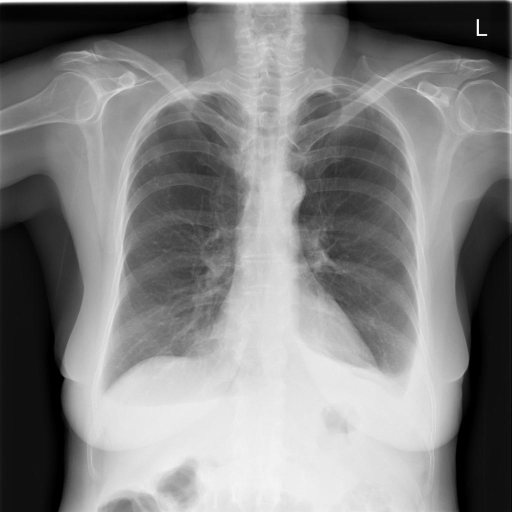

In [19]:
import textwrap
for line in textwrap.wrap(chat_completion.choices[0].message.content, replace_whitespace=False):
    print(line)
display(im_)